In [1]:
import cartopy.crs as ccrs
import cosima_cookbook as cc
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean as cm
from dask.distributed import Client
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Avoid the Runtime errors in true_divide encountered when trying to divide by zero
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)

# matplotlib stuff:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline

matplotlib.rc('xtick', labelsize = 8) 
matplotlib.rc('ytick', labelsize = 8)

from gsw import SA_from_SP, p_from_z, CT_from_pt, rho
from gsw import rho
import xgcm
import cartopy.feature as cft

from sklearn import preprocessing
import xgcm
from xhistogram.xarray import histogram

In [2]:
import logging
logger = logging.getLogger("distributed.utils_perf")
logger.setLevel(logging.ERROR)

In [3]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 251.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38321,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 251.20 GiB
Comm: tcp://127.0.0.1:36997,Total threads: 4
Dashboard: /proxy/43179/status,Memory: 62.80 GiB
Nanny: tcp://127.0.0.1:46847,


In [4]:
db = '/scratch/x77/db6174/mom_old/archive/databases/025deg_jra55_ryf/cc_database_control_hh5.db'
session_cont = cc.database.create_session(db)

db = '/scratch/x77/db6174/mom_old/archive/databases/025deg_jra55_ryf/cc_database_uniform_warming_hh5.db'
session_glob = cc.database.create_session(db)

session = [session_cont, session_glob]
expt = ['025deg_jra55_ryf_control', '025deg_jra55_ryf_fluxH_pos5W_globe']
name = ['Control', '+5W m$^{-2}$ uniform']

In [5]:
grav = 9.81
omega = (2*np.pi)/86400
r0 = 6.371 * 10**6

x_min = [-100, -250, -70, -220, -70, -250]
x_max = [ 10 , -100,  20, -100 ,  20, -80 ]
y_min = [ 20 ,  20 , -42 ,-40 , -80, -80 ]
y_max = [ 75 ,  75 , -20, -20 , -55, -55 ]
basin = ['NA', 'NP', 'SA', 'SP', 'WG', 'RG']

ncoarse = 12
fs = 20 ## Fontsize
rho0 = 1036

In [6]:
start_time = '2202-01-01'
end_time = '2301-12-31'

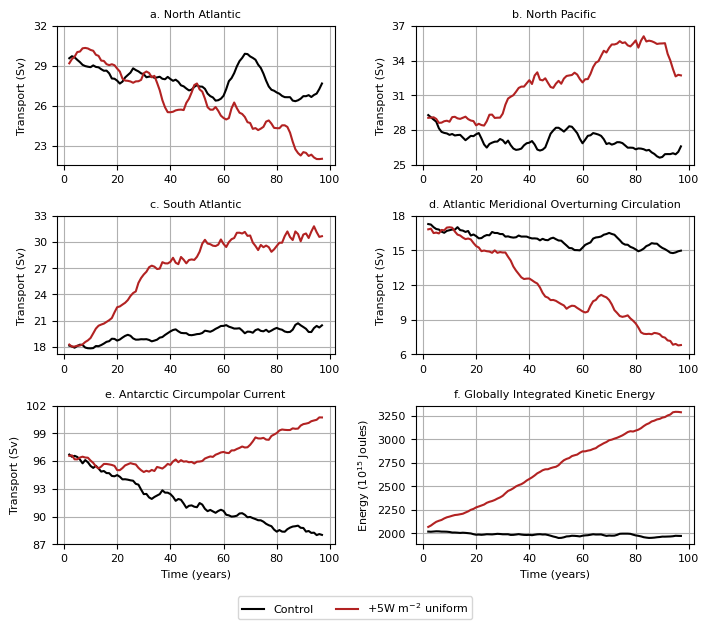

In [7]:
time_val = np.linspace(0 + 2, 95 + 2, 96)

cmap = ['Black', 'firebrick']
name = ['Control', '+5W m$^{-2}$ uniform']

dir_name = ['NA_STG', 'NP_STG', 'SA_STG', 'SP_STG']
name_basin = ['a. North Atlantic', 'b. North Pacific', 'c. South Atlantic']

fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (6 * 1.2, 5 * 1.2))
for i, j in enumerate(dir_name[0:3]):
    psi = xr.open_dataset('NETCDF/Gyre_95th/' + dir_name[i] + '/psi_iso95_pos5Wglobe_STG.nc')
    psi = psi.to_array().mean('variable')

    for k in np.linspace(0, 1, 2):
        if(i == 0):
            psi.isel(expt = int(k)).plot(color = cmap[int(k)], label = name[int(k)], ax = axes[int(i/2)][int(i%2)])
        else:
            if(j == 'SA_STG' or j == 'SP_STG'):
                (-1 * psi).isel(expt = int(k)).plot(color = cmap[int(k)], ax = axes[int(i/2)][int(i%2)])
            else:
                psi.isel(expt = int(k)).plot(color = cmap[int(k)], ax = axes[int(i/2)][int(i%2)])
    axes[int(i/2)][int(i%2)].grid()
    axes[int(i/2)][int(i%2)].set_title(name_basin[i], fontsize = 8)
    axes[int(i/2)][int(i%2)].set_xlabel('')
    
axes[0][0].set_yticks([23, 26, 29, 32])
axes[0][1].set_yticks([25, 28, 31, 34, 37])
axes[1][0].set_yticks([18, 21, 24, 27, 30, 33])

axes[0][0].set_ylabel('Transport (Sv)', fontsize = 8)
axes[0][1].set_ylabel('Transport (Sv)', fontsize = 8)
axes[1][0].set_ylabel('Transport (Sv)', fontsize = 8)

for i, j in enumerate(session):
    
    ## Plotting AMOC
    psi_amoc = cc.querying.getvar(expt[i], 'ty_trans_rho', session = session[i], use_cftime = True, start_time = start_time, end_time = end_time).sel(
        grid_xt_ocean = slice(-103, -5)).sum('grid_xt_ocean').sel(method = 'Nearest', grid_yu_ocean = 26)*1.0e-9
    psi_amoc = psi_amoc.sel(time = slice(start_time, end_time))
    psi_amoc_sum = psi_amoc.cumsum('potrho') - psi_amoc.sum('potrho')
    psi_amoc_sum = psi_amoc_sum.sel(potrho = slice(1035.5, None)).max('potrho').resample(time = 'Y').mean()
    axes[1][1].plot(time_val, psi_amoc_sum.rolling(time = 5, center = True).mean().dropna("time"), color = cmap[i])
    axes[1][1].set_xlabel('', fontsize = 8)
    axes[1][1].set_ylabel('Transport (Sv)', fontsize = 8)
    axes[1][1].set_title('d. Atlantic Meridional Overturning Circulation', fontsize = 8)

    ## Plotting DP Transport
    xmin = -69.9
    ymin = -71.6
    ymax = -51.0
    rho0 = 1036
    
    DP_trans = cc.querying.getvar(expt[i], 'tx_trans_int_z', session = session[i], use_cftime = True).sel(
        xu_ocean = xmin, method='nearest').sel(yt_ocean = slice(ymin, ymax)).sum('yt_ocean')/rho0/1e6
    DP_trans = DP_trans.sel(time = slice(start_time, end_time))
    DP_trans = DP_trans.coarsen({"time": ncoarse}, boundary = "trim").mean()
    axes[2][0].plot(time_val, DP_trans.rolling(time = 5, center = True).mean().dropna("time"), color = cmap[i])
    axes[2][0].set_xlabel('', fontsize = 8)
    axes[2][0].set_ylabel('Transport (Sv)', fontsize = 8)
    axes[2][0].set_title('e. Antarctic Circumpolar Current', fontsize = 8)
    
    ke = cc.querying.getvar(expt = expt[i], session = session[i], variable = 'ke_tot', use_cftime = True)
    ke = ke.sel(time = slice(start_time, end_time))
    ke = ke.coarsen({"time": 364}, boundary = "trim").mean()
    axes[2][1].plot(time_val, ke.rolling(time = 5, center = True).mean().dropna("time"), color = cmap[i])
    axes[2][1].set_xlabel('Time (years)', fontsize = 8)
    axes[2][1].set_ylabel('Energy ($10^{15}$ Joules)', fontsize = 8)
    axes[2][1].set_title('f. Globally Integrated Kinetic Energy', fontsize = 8)
    
axes[1][1].grid()
axes[2][0].grid()
axes[2][1].grid()

axes[2][0].set_xlabel('Time (years)', fontsize = 8)
axes[1][1].set_yticks([6, 9, 12, 15, 18])
axes[2][0].set_yticks([87, 90, 93, 96, 99, 102])

fig.legend(bbox_to_anchor = (0.5, -0.05), loc = 'lower center', ncol = 2, fontsize = 8)
plt.tight_layout()

#plt.savefig('/g/data/x77/db6174/Flux_forced_models/2022_paper_figures/Figures/Global_heat_flux/All_stuff.pdf', bbox_inches = 'tight', dpi = 300, transparent=True)